<center><h1> K-Nearest Neighbours on Udemy SUV Purchases Datasest</h1></center> 

<center><h4> Nyasha M, 15 May 2021 </h4></center>
<p>&nbsp;</p>

**Background:**
A K-Nearest Neighbour (KNN) algorithm was run on the SUV Purchase Dataset from the KNN course in the *Machine Learning A-Z™: Hands-On Python & R In Data Science* program by Kirill Eremenko and Hadelin de Ponteves. The dataset contains customer purchase information from a car dealership after just releasing a new SUV. There are 3 columns, with the dependent variable (purchase decision) expressed as a binary outcome--0 for no purchase of the new SUV, 1 for purchase.

The KNN course was **only used to source the dataset**, but other than that, the other steps (e.g., stratified cross-validation, standardization) were done on my own, based on my knowledge from my Master's in Epidemiology, coursework in biostatistics, the other remainder parts of the course as well as from other data science courses. Part of this knowledge includes knowing that Euclidian distance in KNN depends on standardized data (dummies being an exception to being transformed by standardization/normalization).

**Objective:**
The goal of this notebook was to be able to predict whether a customer would either purchase or not purchase the car dealership's brand-new SUV. I mostly did this notebook to create another sample of classification work for my portfolio.

---
### Package Imports and Data Exploration

In [370]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc

# Modeling
import sklearn.preprocessing as preprocess
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Metrics
from sklearn.metrics import balanced_accuracy_score, classification_report, plot_confusion_matrix, cohen_kappa_score, recall_score, precision_score, roc_curve, roc_auc_score

Let's first load and preview our dataset.

In [360]:
# load the dataset.
df = pd.read_csv("SUV_purchase.csv")
df.head(3)

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0


In [361]:
df.Purchased.value_counts()

0    257
1    143
Name: Purchased, dtype: int64

Note `Purchased` being expressed as a binary variable. How many observations do we have?

In [6]:
len(df)

400

Are there any missing values?

In [7]:
df[df.loc[:, :].isna().any(axis=1) == True]

,Age,EstimatedSalary,Purchased


Checking the distributions of the data.

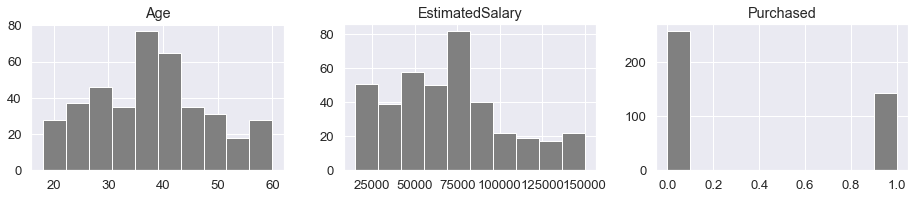

In [343]:
df[df.columns].hist(figsize=(13,3), color='grey', layout=(1,3))
plt.tight_layout()
plt.show()

### Train-test Splits and Standardization

Out outcome (target variable) here is whether the customer made a purchase or not (0 = No, 1 = Yes). Note that its distribution is uneven between the two classes, so stratified splitting/sampling might be a good approach here.

Furthermore, I plan to create a validation set in order to test a couple different numbers of neighbours for my KNN model. The final number of neighbours I like will then be placed into a KNN which predicts for our outcome in the test set.

In [66]:
x, y = df.loc[:, 'Age':'EstimatedSalary'], df['Purchased']

In [336]:
# Create train and test splits of the data.
seed = 100
test_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed, stratify=y)

# Make validation set.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=seed, stratify=y_train)

Are the proportions of train/validation/test data correct? I wanted to do a 60:20:20 split.

In [340]:
print(f"Train: {len(x_train)/400}, Validation: {len(x_val)/400}, Test: {len(x_test)/400}") # Check if the proportions are good.

Train: 0.6, Validation: 0.2, Test: 0.2


In [344]:
# Now standardize the data. We only need to apply this onto the numerical, non-binary data
sc = preprocess.StandardScaler()
x_train = sc.fit_transform(x_train.loc[:, :'EstimatedSalary'])
x_val = sc.transform(x_val.loc[:, :'EstimatedSalary'])
x_test = sc.transform(x_test.loc[:, :'EstimatedSalary'])

x_train[:5]

array([[ 2.06618964,  1.17676263],
       [-0.83263196, -1.20730854],
       [-0.27156971,  0.31253683],
       [ 0.38300291, -0.43248541],
       [-0.45859046, -0.81989697]])

### Model Deployment

Let's try running our KNN with multiple different numbers of neighbours and measure its performance when predicting on the validation set.

In [345]:
acc = [np.nan]*16
kappa = [np.nan]*16
prec = [np.nan]*16
recall = [np.nan]*16
for n in range(2, 18):
    knn = KNeighborsClassifier(n_neighbors=n, metric='minkowski', p=2) # p=2 for euclidean distance
    knn.fit(x_train, y_train)
    
    y_pred = knn.predict(x_val)
    acc[n-2] = balanced_accuracy_score(y_val, y_pred)
    kappa[n-2] = cohen_kappa_score(y_val,y_pred)
    prec[n-2] = precision_score(y_val,y_pred)
    recall[n-2] = recall_score(y_val,y_pred)

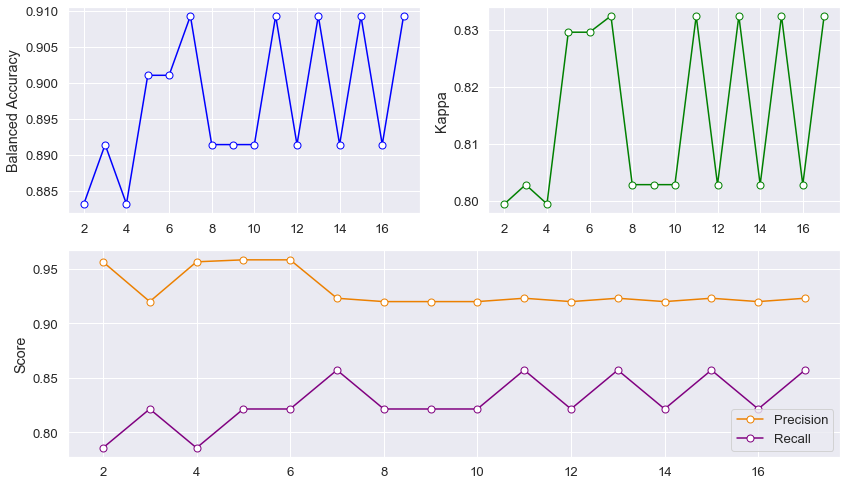

In [346]:
plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2,2,1)
ax1.plot(range(2,18), acc, color='blue', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=14)
ax1.set_xticks(range(2,18,2)), ax1.set_ylabel('Balanced Accuracy')

ax2 = plt.subplot(2,2,2)
ax2.plot(range(2,18), kappa, color='green', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=14)
ax2.set_xticks(range(2,18,2)), ax2.set_ylabel('Kappa')

ax3 = plt.subplot(2,1,2)
ax3.plot(range(2,18), prec, color='#EC8000', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=14, label='Precision')
ax3.plot(range(2,18), recall, color='purple', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=14, label='Recall')
ax3.set_ylabel('Score')
ax3.legend()

plt.tight_layout()
plt.show()

N = 6, 7, and 11 all look like they might be best. Let's try these ones on the test set. **Note:** After randomly trying each of these 3, 11 turned out to be best.

In [354]:
knn = KNeighborsClassifier(n_neighbors=11, metric='minkowski', p=2) # p=2 for euclidean distance
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [355]:
y_pred = knn.predict(x_test)

### Model Performance on Test Set

In [356]:
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {accuracy*100:.2f}% \n")

print(classification_report(y_test, y_pred, digits=2))

print(f"Cohen's Kappa: {cohen_kappa_score(y_test,y_pred):.3f}") # 'substantial' agreement between the predicted and test results.

Balanced accuracy: 92.63% 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        51
           1       0.87      0.93      0.90        29

    accuracy                           0.93        80
   macro avg       0.92      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80

Cohen's Kappa: 0.840


In [ ]:
y_probas = knn.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probas) # For ROC curve

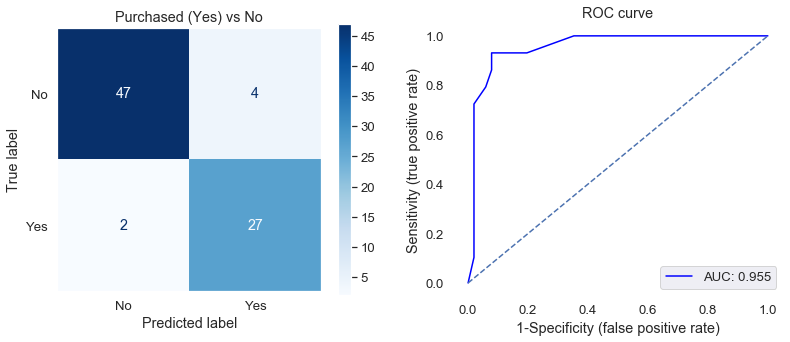

In [438]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
plot_confusion_matrix(knn, x_test, y_test, cmap='Blues', display_labels=['No', 'Yes'], ax=axs[0])
axs[0].grid(False), axs[0].set_title('Purchased (Yes) vs No')

axs[1].set_facecolor("white")
axs[1].plot(fpr, tpr, color='blue', label=f"AUC: {roc_auc_score(y_test, y_probas).round(3)}")
axs[1].legend()
axs[1].set_title("ROC curve")
axs[1].set_ylabel("Sensitivity (true positive rate)"), axs[1].set_xlabel("1-Specificity (false positive rate)")
axs[1].plot([(i/10) for i in range(11)], [(i/10) for i in range(11)], linestyle='--')
#fig.tight_layout()
plt.show()

We have very high agreement between our predicted and test values for our outcome (Kappa statistic) as well as a high c-statistic (AUC). What about a cross-validated measure for our balanced accuracy?

In [358]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) # imbalanced classes
cv_results = cross_val_score(knn, x_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [364]:
print(f"Mean cross-validated balanced accuracy: {np.mean(cv_results):.3f}, SD: {np.std(cv_results):.3f}")

Mean cross-validated balanced accuracy: 0.904, SD: 0.061


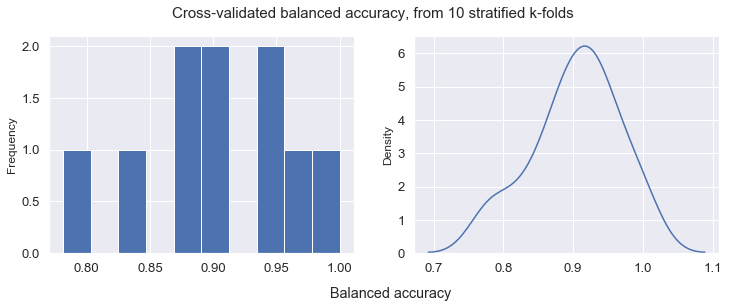

In [365]:
fig, axs=plt.subplots(1,2,figsize=(12,4))
axs[0].hist(cv_results), axs[0].set_ylabel('Frequency', fontsize=12)

sns.kdeplot(cv_results, ax=axs[1]), axs[1].set_ylabel('Density', fontsize=12)

plt.suptitle('Cross-validated balanced accuracy, from 10 stratified k-folds', fontsize=15)
fig.text(0.45,-0.03, 'Balanced accuracy')
plt.show()

### Conclusions

We can confirm that our KNN model did an overall great job at classifying our binary outcome, and the ideal number of neighbours for this problem was N = 11 neighbours.

Our KNN model with 11 neighbours had a 90.4% (SD 6.1%) cross-validated balanced accuracy in predicting whether a customer would want to purchase the new SUV or not.